# UCI Machine Learning Adult dataset

Implementation of variants of Expected Value Mechanism.

MIT License
Copyright (C) 2022

Dataset can be downloaded from https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import time

filename_train = 'data/adult_train.csv'
filename_test = 'data/adult_test.csv'

data_train = pd.read_csv(filename_train, header=None, na_values=' ?')
data_test = pd.read_csv(filename_test, header=None, na_values=' ?', skiprows=1)

data_all = pd.concat([data_train, data_test], axis=0, ignore_index=True)
data_all = data_all.dropna()
print(data_all.shape)

(45222, 15)


In [2]:
NUM_DATA_SHADOW = 100
NUM_DATA_TEST = 100

MINI_DATASET_SIZE = 100

In [3]:
# sensitive attributes: Income, Workclass
INCOME_INDEX = 14
WORKCLASS_INDEX = 1
# possible tasks
AGE_INDEX = 0
EDUCATION_YEARS_INDEX = 4
MARITAL_STATUS_INDEX = 5
SEX_INDEX = 9
HOURS_INDEX = 12

data_high_income = data_all[data_all[INCOME_INDEX].isin([' >50K', ' >50K.'])]
data_low_income = data_all[data_all[INCOME_INDEX].isin([' <=50K', ' <=50K.'])]

# data_high_income = data_all[data_all[WORKCLASS_INDEX] == ' Private']
# data_low_income = data_all[data_all[WORKCLASS_INDEX] != ' Private']

sens_att = 'I'
def set_sens_att(sens_att_val):
    sens_att = sens_att_val
    if sens_att == 'I':
        data_high_income = data_all[data_all[INCOME_INDEX].isin([' >50K', ' >50K.'])]
        data_low_income = data_all[data_all[INCOME_INDEX].isin([' <=50K', ' <=50K.'])]
    else:
        data_high_income = data_all[data_all[WORKCLASS_INDEX] == ' Private']
        data_low_income = data_all[data_all[WORKCLASS_INDEX] != ' Private']
    
    return sens_att, data_high_income, data_low_income

In [4]:
print(data_high_income.shape[0], data_low_income.shape[0], data_high_income.shape[0] + data_low_income.shape[0])

11208 34014 45222


In [5]:
SAMPLE_SIZE = MINI_DATASET_SIZE
# HIGH_INCOME_RATIO1 = 0.4
# HIGH_INCOME_RATIO2 = 0.6

# # data_theta a dataframe of records
# # sample a sub-dataset from data_theta
# # and returns some statistics, e.g. average age, num females, etc.
# def get_data(data_theta):
#     sample = data_theta.sample(SAMPLE_SIZE)

#     data = []
#     data.append(np.mean(sample[AGE_INDEX]))
#     data.append(np.mean(sample[EDUCATION_YEARS_INDEX]))
#     data.append(sample[SEX_INDEX].value_counts()[' Female'])
#     data.append(np.mean(sample[HOURS_INDEX]))

#     return np.array(data)

def get_data(data_hi, data_lo, hi_ratio):
    num_hi = round(hi_ratio * SAMPLE_SIZE)
    num_lo = SAMPLE_SIZE - num_hi

#     start = time.time()
    
    sample_hi = data_hi.sample(num_hi)
    sample_lo = data_lo.sample(num_lo)
    sample = pd.concat([sample_hi, sample_lo], ignore_index = True)
    
#     end = time.time()
#     print(end - start)
    
#     start = time.time()

    data = []
    data.append(np.mean(sample[AGE_INDEX]))
    data.append(np.mean(sample[EDUCATION_YEARS_INDEX]))
    
    ms_counts = sample[MARITAL_STATUS_INDEX].value_counts()
    if ' Never-married' in ms_counts.keys():
        data.append(ms_counts[' Never-married'])
    else:
        data.append(0)
    
    s_counts = sample[SEX_INDEX].value_counts()
    if ' Female' in s_counts.keys():
        data.append(s_counts[' Female'])
    else:
        data.append(0)

    data.append(np.mean(sample[HOURS_INDEX]))

#     end = time.time()
#     print(end - start)

    return np.array(data)

In [6]:
get_data(data_high_income, data_low_income, 0.4)

array([38.69, 10.54, 24.  , 32.  , 41.09])

In [7]:
get_data(data_high_income, data_low_income, 0.6)

array([42.96, 10.73, 23.  , 28.  , 41.51])

## Property inference attack

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# NUM_DATA_SHADOW_AUX = 5000
SHADOW_EVALUTATION_REPS = 2

def evaluate_shadow_clf(p1, p2):
    accuracies = []
    
    for _ in range(SHADOW_EVALUTATION_REPS):       
        shadow_data_hi, test_data_hi = train_test_split(data_high_income, test_size=0.33)
        shadow_data_lo, test_data_lo = train_test_split(data_low_income, test_size=0.33)
        
        features_shadow = []
        features_test = []
        labels_shadow = []
        labels_test = []
        
#         start = time.time()
        
        for _ in range(NUM_DATA_SHADOW):
            features_shadow.append(get_data(shadow_data_hi, shadow_data_lo, p1))
            labels_shadow.append(1)
            features_shadow.append(get_data(shadow_data_hi, shadow_data_lo, p2))
            labels_shadow.append(2)

        for _ in range(NUM_DATA_TEST):
            features_test.append(get_data(test_data_hi, test_data_lo, p1))
            labels_test.append(1)
            features_test.append(get_data(test_data_hi, test_data_lo, p2))
            labels_test.append(2)
            
#         end = time.time()
#         print(end - start)

        clf = LogisticRegression().fit(features_shadow, labels_shadow)
        accuracies.append(clf.score(features_test, labels_test))

    return accuracies

In [10]:
start = time.time()
print(evaluate_shadow_clf(0.4, 0.6))
# print(np.mean(evaluate_shadow_clf(0.4, 0.6)))
end = time.time()
print("time:", end - start)

[0.925, 0.91]
time: 2.589740514755249


In [126]:
p_diff_values = np.linspace(0.01, 0.2, 20)
attack_p_diff = []
for p_diff in p_diff_values:
    attack_p_diff.append(evaluate_shadow_clf(0.5 - p_diff, 0.5 + p_diff))

In [127]:
# attack_p_diff

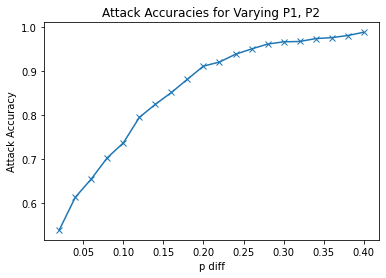

In [129]:
import matplotlib
import matplotlib.pyplot as plt

plt.clf()

plt.plot(2 * p_diff_values, np.mean(attack_p_diff, axis=1), marker='x')
plt.xlabel('p diff')
plt.ylabel("Attack Accuracy")
plt.title("Attack Accuracies for Varying P1, P2")

# plt.show()
# plt.savefig('attack_accuracies.pgf')

import tikzplotlib
tikzplotlib.save("a_attack_income.tikz")

## Approximating with Gaussians

In [11]:
NUM_DATA_POINTS = 1000

p1 = 0.45
p2 = 0.55

data_points_theta1 = []
data_points_theta2 = []
for _ in range(NUM_DATA_POINTS):
    data_points_theta1.append(get_data(data_high_income, data_low_income, p1))
    data_points_theta2.append(get_data(data_high_income, data_low_income, p2))

data_points_theta1 = pd.DataFrame(data_points_theta1)
data_points_theta2 = pd.DataFrame(data_points_theta2)

mu1 = data_points_theta1.mean()
mu2 = data_points_theta2.mean()
cov1 = data_points_theta1.cov()
cov2 = data_points_theta2.cov()

# data_points_all = pd.concat([data_points_theta1, data_points_theta2], ignore_index=True)
cov = (cov1 + cov2) / 2

# so that I can repeat experiments without having to rerun the cell...
def set_p1p2(p1_val, p2_val):
    # global variables
    p1 = p1_val
    p2 = p2_val

    data_points_theta1 = []
    data_points_theta2 = []
    for _ in range(NUM_DATA_POINTS):
        data_points_theta1.append(get_data(data_high_income, data_low_income, p1))
        data_points_theta2.append(get_data(data_high_income, data_low_income, p2))

    data_points_theta1 = pd.DataFrame(data_points_theta1)
    data_points_theta2 = pd.DataFrame(data_points_theta2)

    mu1 = data_points_theta1.mean()
    mu2 = data_points_theta2.mean()
    cov1 = data_points_theta1.cov()
    cov2 = data_points_theta2.cov()

    # data_points_all = pd.concat([data_points_theta1, data_points_theta2], ignore_index=True)
    cov = (cov1 + cov2) / 2
    
    return p1, p2, data_points_theta1, data_points_theta2, mu1, mu2, cov1, cov2, cov

In [32]:
sens_att, data_high_income, data_low_income = set_sens_att('W')
p1, p2, data_points_theta1, data_points_theta2, mu1, mu2, cov1, cov2, cov = set_p1p2(0.45, 0.55)

for i in range(mu1.shape[0]):
    print("{:.2f}".format(mu1[i]))
print()
for i in range(mu2.shape[0]):
    print("{:.2f}".format(mu2[i]))

print()
print(sens_att, p1, p2)
print()
print(np.linalg.norm(mu1 - mu2, ord=1), np.linalg.norm(mu1 - mu2, ord=2))

40.30
10.39
28.19
30.66
41.69

39.72
10.29
29.52
31.08
41.44

W 0.45 0.55

2.6782199999999996 1.5335926255691257


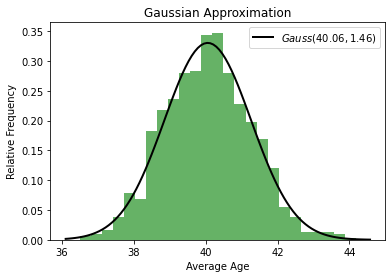

In [31]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fi = 0  # feature index
data_points_theta_i = data_points_theta1
mu_i = mu1
cov_i = cov1

# Plot the histogram.
plt.hist(data_points_theta_i[fi], bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu_i[fi], np.sqrt(cov_i[fi][fi]))
plt.xlabel('Average Age')
plt.ylabel("Relative Frequency")
plt.title("Gaussian Approximation")
plt.plot(x, p, 'k', linewidth=2, label='$Gauss({:.2f},{:.2f})$'.format(mu_i[fi], cov_i[fi][fi]))
plt.legend(loc="upper right")

# # Plot the histogram.
# plt.hist(data_points_theta1[feature_index], bins=25, density=True, alpha=0.6, color='g')

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = stats.norm.pdf(x, mu1[feature_index], np.sqrt(cov1[feature_index][feature_index]))
# plt.plot(x, p, 'k', linewidth=2)

# plt.show()

import tikzplotlib
tikzplotlib.save("a_model_age_1000_p45_income.tikz")

## Mechanisms

In [12]:
# apply noise according to Laplace variant of Expected Value Mechanism (ExpM (L))
def ev_laplace(data, eps):
    scale = np.linalg.norm(mu1 - mu2, ord=1) / eps
    return data + np.random.laplace(0, scale, mu1.shape)

In [13]:
# apply noise according to Laplace variant of Directional Expected Value Mechanism (DirM (L))
def dir_laplace(data, eps):
    scale = np.linalg.norm(mu1 - mu2, ord=2) / eps
    v_dir = mu1 - mu2
    v_dir = v_dir / np.linalg.norm(v_dir)
    return data + np.random.laplace(0, scale) * v_dir

In [14]:
# apply noise according to Gaussian variant of Expected Value Mechanism (ExpM (G))
def ev_gauss(data, eps, delta):
    c = np.sqrt(2 * np.log(1.25 / delta))
    scale = c * np.linalg.norm(mu1 - mu2) / eps
#     print(scale)
    return data + np.random.normal(0, scale, mu1.shape)

In [15]:
# apply noise according to Eigenvector Gaussian Mechanism (EigM (G))
def gauss_red(data, eps, delta):
    ndim = data.shape[0]
    c = np.sqrt(2 * np.log(1.25 / delta))
    
    # need to increase all eigenvalues to be at least this value
    min_eigval = (c * np.linalg.norm(mu1 - mu2) / eps) ** 2
#     print(c, min_eigval)
    
    eigvals, eigvecs = np.linalg.eigh(cov)
    eigvecs = eigvecs.T
    
    cov_to_add = np.zeros((ndim, ndim))
    for i in range(ndim):
        eigval = eigvals[i]
        eigvec = eigvecs[i]
        if eigval < min_eigval:
            cov_to_add += (min_eigval - eigval) * np.outer(eigvec, eigvec)
    
#     print(cov_to_add, min_eigval)
    
    return data + np.random.multivariate_normal(np.zeros(ndim), cov_to_add)

In [16]:
# apply noise according to Directional Gaussian Mechanism with Adversarial Uncertainty (DauM (G))
def gauss_dir(data, eps, delta):
    ndim = data.shape[0]
    c = np.sqrt(2 * np.log(1.25 / delta))
    alpha = np.linalg.norm(mu1 - mu2)
    v_dir = mu1 - mu2
    v_dir = v_dir / np.linalg.norm(v_dir)
    dir_to_add = np.outer(v_dir, v_dir)
    
    cov_cur = cov
    sig_lo = 0
    sig_hi = (alpha * c / eps) ** 2
    while sig_hi > sig_lo + 0.001:
        sig_mid = (sig_hi + sig_lo) / 2
        eigs_new = np.linalg.eigh(cov_cur + (sig_mid - (alpha * c / eps) ** 2) * dir_to_add)
        if (min(eigs_new[0]) > 0):
            sig_hi = sig_mid
        else:
            sig_lo = sig_mid
    
    return data + np.random.multivariate_normal(np.zeros(ndim), sig_hi * dir_to_add)

Baselines (GroupDP)

In [17]:
sens_age = (max(data_all[AGE_INDEX]) - min(data_all[AGE_INDEX])) / MINI_DATASET_SIZE
sens_ey = (max(data_all[EDUCATION_YEARS_INDEX]) - min(data_all[EDUCATION_YEARS_INDEX])) / MINI_DATASET_SIZE
sens_nnm = 1
sens_nf = 1
sens_hours = (max(data_all[HOURS_INDEX]) - min(data_all[HOURS_INDEX])) / MINI_DATASET_SIZE

sens_all = [sens_age, sens_ey, sens_nnm, sens_nf, sens_hours]

print(sens_all)

sens_F1 = np.linalg.norm(sens_all, ord=1)
sens_F2 = np.linalg.norm(sens_all, ord=2)

print(sens_F1, sens_F2)

def gdp_l(data, k, eps):
    scale = k * sens_F1 / eps
    return data + np.random.laplace(0, scale, mu1.shape)

def gdp_g(data, k, eps, delta):
    c = np.sqrt(2 * np.log(1.25 / delta))
    scale = c * k * sens_F2 / eps
    return data + np.random.normal(0, scale, mu1.shape)

[0.73, 0.15, 1, 1, 0.98]
3.86 1.8750466660859402


## Utility

In [127]:
eps = 1
delta = 0.001

data = get_data(data_high_income, data_low_income, p1)
data_evl = ev_laplace(data, eps)
data_dirl = dir_laplace(data, eps)
data_evg = ev_gauss(data, eps, delta)
data_gr = gauss_red(data, eps, delta)
data_dir = gauss_dir(data, eps, delta)
# data_gdp_l = gdp_l(data, MINI_DATASET_SIZE, eps)
# data_gdp_g = gdp_g(data, MINI_DATASET_SIZE, eps, delta)
data_gdp_l = gdp_l(data, 1, eps)
data_gdp_g = gdp_g(data, 1, eps, delta)

print(data)
print(data_evl)
print(data_dirl)
print(data_evg)
print(data_gr)
print(data_dir)
print(data_gdp_l)
print(data_gdp_g)

[38.81 10.53 26.   33.   42.39]
[53.9416178   4.26367658 15.13247894 35.40953523 44.80234773]
0    38.420257
1    10.424068
2    27.848052
3    34.587939
4    42.037507
dtype: float64
[ 9.18451679 10.06486216 11.81060411 34.4402442  23.11169511]
[42.58008365  4.83900925  8.34763301 20.6584414  62.17500734]
[40.58703178 11.01299497 17.57381798 25.75979873 43.99719037]
[29.05948114  9.55237606 25.07916105 41.13434145 38.77990241]
[33.08522443 33.32895412 26.9647017  31.9742393  41.77687883]


In [128]:
NREPS = 50

def evaluate_util(eps, delta, norm_ord):
    util_evl = []
    util_dir_l = []
    util_evg = []
    util_gr = []
    util_dir = []
    util_gdpl = []
    util_gdpg = []
    
    for _ in range(NREPS):        
        data = get_data(data_high_income, data_low_income, p1)
        data_evl = ev_laplace(data, eps)
        data_dirl = dir_laplace(data, eps)
        data_evg = ev_gauss(data, eps, delta)
        data_gr = gauss_red(data, eps, delta)
        data_dir = gauss_dir(data, eps, delta)
        # data_gdp_l = gdp_l(data, MINI_DATASET_SIZE, eps)
        # data_gdp_g = gdp_g(data, MINI_DATASET_SIZE, eps, delta)
        data_gdp_l = gdp_l(data, 1, eps)
        data_gdp_g = gdp_g(data, 1, eps, delta)
        
        util_evl.append(np.linalg.norm(data - data_evl, ord=norm_ord))
        util_dir_l.append(np.linalg.norm(data - data_dirl, ord=norm_ord))
        util_evg.append(np.linalg.norm(data - data_evg, ord=norm_ord))
        util_gr.append(np.linalg.norm(data - data_gr, ord=norm_ord))
        util_dir.append(np.linalg.norm(data - data_dir, ord=norm_ord))
        util_gdpl.append(np.linalg.norm(data - data_gdp_l, ord=norm_ord))
        util_gdpg.append(np.linalg.norm(data - data_gdp_g, ord=norm_ord))
        
    return util_evl, util_dir_l, util_evg, util_gr, util_dir, util_gdpl, util_gdpg

In [129]:
norm_ord = 2
a1, a2, a3, a4, a5, a6, a7 = evaluate_util(2, 0.001, norm_ord)

In [130]:
np.mean(a1), np.mean(a2), np.mean(a3), np.mean(a4), np.mean(a5), np.mean(a6), np.mean(a7)

(10.125339086460102,
 3.6542793781094383,
 18.9961084582726,
 18.086385453554126,
 5.748118471777974,
 5.5392572435900185,
 7.960207567129832)

## Attack vs mechanism

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


SHADOW_EVALUTATION_REPS = 50

def evaluate_shadow_clf_with_mech(eps, delta):
    accuracies_no = []
    accuracies_evl = []
    accuracies_dirl = []
    accuracies_evg = []
    accuracies_gr = []
    accuracies_dir = []
    accuracies_gdpl = []
    accuracies_gdpg = []
    
    for i in range(SHADOW_EVALUTATION_REPS):

        shadow_data_hi, test_data_hi = train_test_split(data_high_income, test_size=0.33)
        shadow_data_lo, test_data_lo = train_test_split(data_low_income, test_size=0.33)
        
        features_shadow = []
        features_test = []
        labels_shadow = []
        labels_test = []
        
        for _ in range(NUM_DATA_SHADOW):
            features_shadow.append(get_data(shadow_data_hi, shadow_data_lo, p1))
            labels_shadow.append(1)
            features_shadow.append(get_data(shadow_data_hi, shadow_data_lo, p2))
            labels_shadow.append(2)
        
        for _ in range(NUM_DATA_TEST):
            features_test.append(get_data(test_data_hi, test_data_lo, p1))
            labels_test.append(1)
            features_test.append(get_data(test_data_hi, test_data_lo, p2))
            labels_test.append(2)

        clf = LogisticRegression().fit(features_shadow, labels_shadow)
        
        
        features_test_no = []
        features_test_evl = []
        features_test_dirl = []
        features_test_evg = []
        features_test_gr = []
        features_test_dir = []
        features_test_gdpl = []
        features_test_gdpg = []
        
        for feat in features_test:
            features_test_no.append(feat)
            features_test_evl.append(ev_laplace(feat, eps))
            features_test_dirl.append(dir_laplace(feat, eps))
            features_test_evg.append(ev_gauss(feat, eps, delta))
            features_test_gr.append(gauss_red(feat, eps, delta))
            features_test_dir.append(gauss_dir(feat, eps, delta))
            
#             k = 1
            k = MINI_DATASET_SIZE
            features_test_gdpl.append(gdp_l(feat, k, eps))
            features_test_gdpg.append(gdp_g(feat, k, eps, delta))
    

        accuracies_no.append(clf.score(features_test_no, labels_test))
        accuracies_evl.append(clf.score(features_test_evl, labels_test))
        accuracies_dirl.append(clf.score(features_test_dirl, labels_test))
        accuracies_evg.append(clf.score(features_test_evg, labels_test))
        accuracies_gr.append(clf.score(features_test_gr, labels_test))
        accuracies_dir.append(clf.score(features_test_dir, labels_test))
        accuracies_gdpl.append(clf.score(features_test_gdpl, labels_test))
        accuracies_gdpg.append(clf.score(features_test_gdpg, labels_test))

    return accuracies_no, accuracies_evl, accuracies_dirl, accuracies_evg,\
        accuracies_gr, accuracies_dir, accuracies_gdpl, accuracies_gdpg

In [120]:
a1, a2, a3, a4, a5, a6, a7, a8 = evaluate_shadow_clf_with_mech(2, 0.001)

In [ ]:
np.mean(a1), np.mean(a2), np.mean(a3), np.mean(a4), np.mean(a5), np.mean(a6), np.mean(a7), np.mean(a8) 

In [19]:
sens_att, data_high_income, data_low_income = set_sens_att('I')
p1, p2, data_points_theta1, data_points_theta2, mu1, mu2, cov1, cov2, cov = set_p1p2(0.45, 0.55)

In [ ]:
NDIM = 5
eps_values = np.logspace(-1, 1, 20)
delt = 0.001
defense_eps = []
for eps in eps_values:
    defense_eps.append(evaluate_shadow_clf_with_mech(eps, delt))

acc_mech = np.array(defense_eps)
acc_mech = np.swapaxes(acc_mech, 0, 1)
acc_mech.shape

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.clf()

plt.plot(eps_values, np.full(len(eps_values), np.mean(acc_mech[0])), label="No defense")
# plt.plot(eps_values, np.mean(acc_mech[1], axis=1), label="ExpM (L)", marker="o", color="r")
# plt.plot(eps_values, np.mean(acc_mech[2], axis=1), label="DirM (L)", marker="s", color="g")
plt.plot(eps_values, np.mean(acc_mech[3], axis=1), label="ExpM (G)", marker="o", color="r")
plt.plot(eps_values, np.mean(acc_mech[4], axis=1), label="EigM (G)", marker="^", color="y")
plt.plot(eps_values, np.mean(acc_mech[5], axis=1), label="DirM (G)", marker="s", color="g")

# plt.plot(eps_values, np.mean(acc_mech[6], axis=1), label="GDP (L)", marker="X", color="dimgray")
plt.plot(eps_values, np.mean(acc_mech[7], axis=1), label="GDP (G)", marker="X", color="dimgray")


plt.xlabel('$\\epsilon$')
plt.ylabel("Attack Accuracy")
plt.title("Attack Accuracies")
plt.legend(loc="center left")
plt.xscale("log")
# plt.show()
# plt.savefig('figures/test.pgf')

# import tikzplotlib
# tikzplotlib.save("a_attack_accuracies_lap_income_p1.tikz")